In [2]:
import sys
import re, numpy as np, pandas as pd
from pprint import pprint

# Gensim
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import lemmatize, simple_preprocess
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])

%matplotlib inline
warnings.filterwarnings("ignore",category=DeprecationWarning)
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

In [3]:
# Import Dataset
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')
df = df.loc[df.target_names.isin(['soc.religion.christian', 'rec.sport.hockey', 'talk.politics.mideast', 'rec.motorcycles']) , :]
print(df.shape)  #> (2361, 3)
df.head(10)

(2361, 3)


,content,target,target_names
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
10007,From: jet@netcom.Netcom.COM (J. Eric Townsend)...,8,rec.motorcycles
10008,From: gld@cunixb.cc.columbia.edu (Gary L Dare)...,10,rec.sport.hockey
10017,From: nstramer@supergas.dazixco.ingr.com (Naft...,17,talk.politics.mideast
10019,From: mussack@austin.ibm.com (Christopher Muss...,15,soc.religion.christian
10020,From: noye@midway.uchicago.edu (vera shanti no...,15,soc.religion.christian
10025,From: infante@acpub.duke.edu (Andrew Infante)...,8,rec.motorcycles
10028,From: jsledd@ssdc.sas.upenn.edu (James Sledd)\...,15,soc.religion.christian
10031,From: rauser@fraser.sfu.ca (Richard John Rause...,10,rec.sport.hockey
10032,From: steveg@cadkey.com (Steve Gallichio)\nSub...,10,rec.sport.hockey


In [4]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', sent)  # remove emails
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent)  

# Convert to list
data = df.content.values.tolist()
print(data)
data_words = list(sent_to_words(data))
print(data_words[:1])
# [['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', ...trucated...]]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[['from', 'irwin', 'arnstein', 'subject', 're', 'recommendation', 'on', 'duc', 'summary', 'whats', 'it', 'worth', 'distribution', 'usa', 'expires', 'sat', 'may', 'gmt', 'organization', 'computrac', 'inc', 'richardson', 'tx', 'keywords', 'ducati', 'gts', 'how', 'much', 'lines', 'have', 'line', 'on', 'ducati', 'gts', 'model', 'with', 'on', 'the', 'clock', 'runs', 'very', 'well', 'paint', 'is', 'the', 'bronze', 'brown', 'orange', 'faded', 'out', 'leaks', 'bit', 'of', 'oil', 'and', 'pops', 'out', 'of', 'st', 'with', 'hard', 'accel', 'the', 'shop', 'will', 'fix', 'trans', 'and', 'oil', 'leak', 'they', 'sold', 'the', 'bike', 'to', 'the', 'and', 'only', 'owner', 'they', 'want', 'and', 'am', 'thinking', 'more', 'like', 'any', 'opinions', 'out', 'there', 'please', 'email', 'me', 'thanks', 'it', 'would', 'be', 'nice', 'stable', 'mate', 'to', 'the', 'beemer', 'then', 'ill', 'get', 'jap', 'bike', 'and', 'call', 'myself', 'axis', 'motors', 'tuba', 'irwin', 'honk', 'therefore', 'am', 'computrac', 'r

In [5]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# !python3 -m spacy download en  # run in terminal once
def process_words(texts, stop_words=stop_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """Remove Stopwords, Form Bigrams, Trigrams and Lemmatization"""
    texts = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
    texts = [bigram_mod[doc] for doc in texts]
    texts = [trigram_mod[bigram_mod[doc]] for doc in texts]
    texts_out = []
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    nlp = spacy.load("en_core_web_sm")
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    # remove stopwords once more after lemmatization
    texts_out = [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts_out]    
    return texts_out

data_ready = process_words(data_words)  # processed Text Data!

In [22]:
# Create Dictionary
id2word = corpora.Dictionary(data_ready)

# Create Corpus: Term Document Frequency
corpus = [id2word.doc2bow(text) for text in data_ready]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10,
                                           passes=10,
                                           alpha='symmetric',
                                           iterations=100,
                                           per_word_topics=True)

In [23]:
# Print the Keyword in the 4 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.015*"armenian" + 0.013*"people" + 0.011*"kill" + 0.011*"israeli" + '
  '0.009*"government" + 0.009*"return" + 0.008*"page" + 0.008*"turkish" + '
  '0.008*"state" + 0.007*"genocide"'),
 (1,
  '0.012*"people" + 0.009*"believe" + 0.008*"write" + 0.008*"law" + '
  '0.007*"question" + 0.006*"give" + 0.006*"talk" + 0.006*"book" + '
  '0.006*"claim" + 0.006*"must"'),
 (2,
  '0.019*"time" + 0.018*"write" + 0.014*"article" + 0.010*"well" + '
  '0.009*"look" + 0.008*"year" + 0.008*"first" + 0.008*"bike" + 0.008*"tell" + '
  '0.008*"organization"'),
 (3,
  '0.038*"team" + 0.034*"game" + 0.023*"player" + 0.022*"play" + '
  '0.020*"season" + 0.018*"hockey" + 0.015*"year" + 0.013*"score" + '
  '0.012*"final" + 0.010*"goal"')]


In [24]:
#What are the Dominant topics and its percentage contribution in each document
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_ready)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.9277,"time, write, article, well, look, year, first, bike, tell, organization","[worth, expire, keyword, ducati, much, ducati, model, clock, well, paint, fade, leak, bit, oil, ..."
1,1,2.0,0.7974,"time, write, article, well, look, year, first, bike, tell, organization","[reply, message, organization, service, write, none, judgemental, little, shit, driven, hungover..."
2,2,2.0,0.6026,"time, write, article, well, look, year, first, bike, tell, organization","[write, boy, rip, hockey, coverage, pittsburgher, thrill, lange, buy, air, time, production, adv..."
3,3,0.0,0.5950,"armenian, people, kill, israeli, government, return, page, turkish, state, genocide","[israeline, report, yesterday, follow, egyptian, prominent, principle, decide, participate, none..."
4,4,1.0,0.6708,"people, believe, write, law, question, give, talk, book, claim, must","[question, authority, trendy, liberal, feminist, tendency, fact, basically, agree, rebut, write,..."
5,5,1.0,0.5107,"people, believe, write, law, question, give, talk, book, claim, must","[harrasse, work, prayer, reply, repeat, feel, horrible, worthless, mean, feel, way, believe, som..."
6,6,2.0,0.7613,"time, write, article, well, look, year, first, bike, tell, organization","[apparently, last, post, little, hasy, call, place, quote, less, liability, course, palce, give,..."
7,7,1.0,0.6036,"people, believe, write, law, question, give, talk, book, claim, must","[social, science, computing, way, look, die, release, time, able, comprehend, life, toto, visit,..."
8,8,2.0,0.5255,"time, write, article, well, look, year, first, bike, tell, organization","[canadien, organization, write, cup, problem, steal, show, play, alone, massive, teamwork, littl..."
9,9,3.0,0.7923,"team, game, player, play, season, hockey, year, score, final, goal","[possible, canadian, point, team, canadian, nhler, center, draft, play, score, goal, season, lef..."


In [25]:
#The most representative sentence for each topic
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8110,"armenian, people, kill, israeli, government, return, page, turkish, state, genocide","[article, write, force, detonate, bomb, israeli, occupation, patrol, soldier, kill, wound, retal..."
1,1.0,0.9714,"people, believe, write, law, question, give, talk, book, claim, must","[people, marry, write, essential, ingredient, marriage, mutual, commitment, person, consider, ma..."
2,2.0,0.9812,"time, write, article, well, look, year, first, bike, tell, organization","[hard, copy, hot, pursuit, organization, reply, previous, article, copy, watch, late, machine, s..."
3,3.0,0.9898,"team, game, player, play, season, hockey, year, score, final, goal","[strouse, play, boxscore, play, standing, title, clinch, playoff, berth, shot, goal, cheveldae, ..."


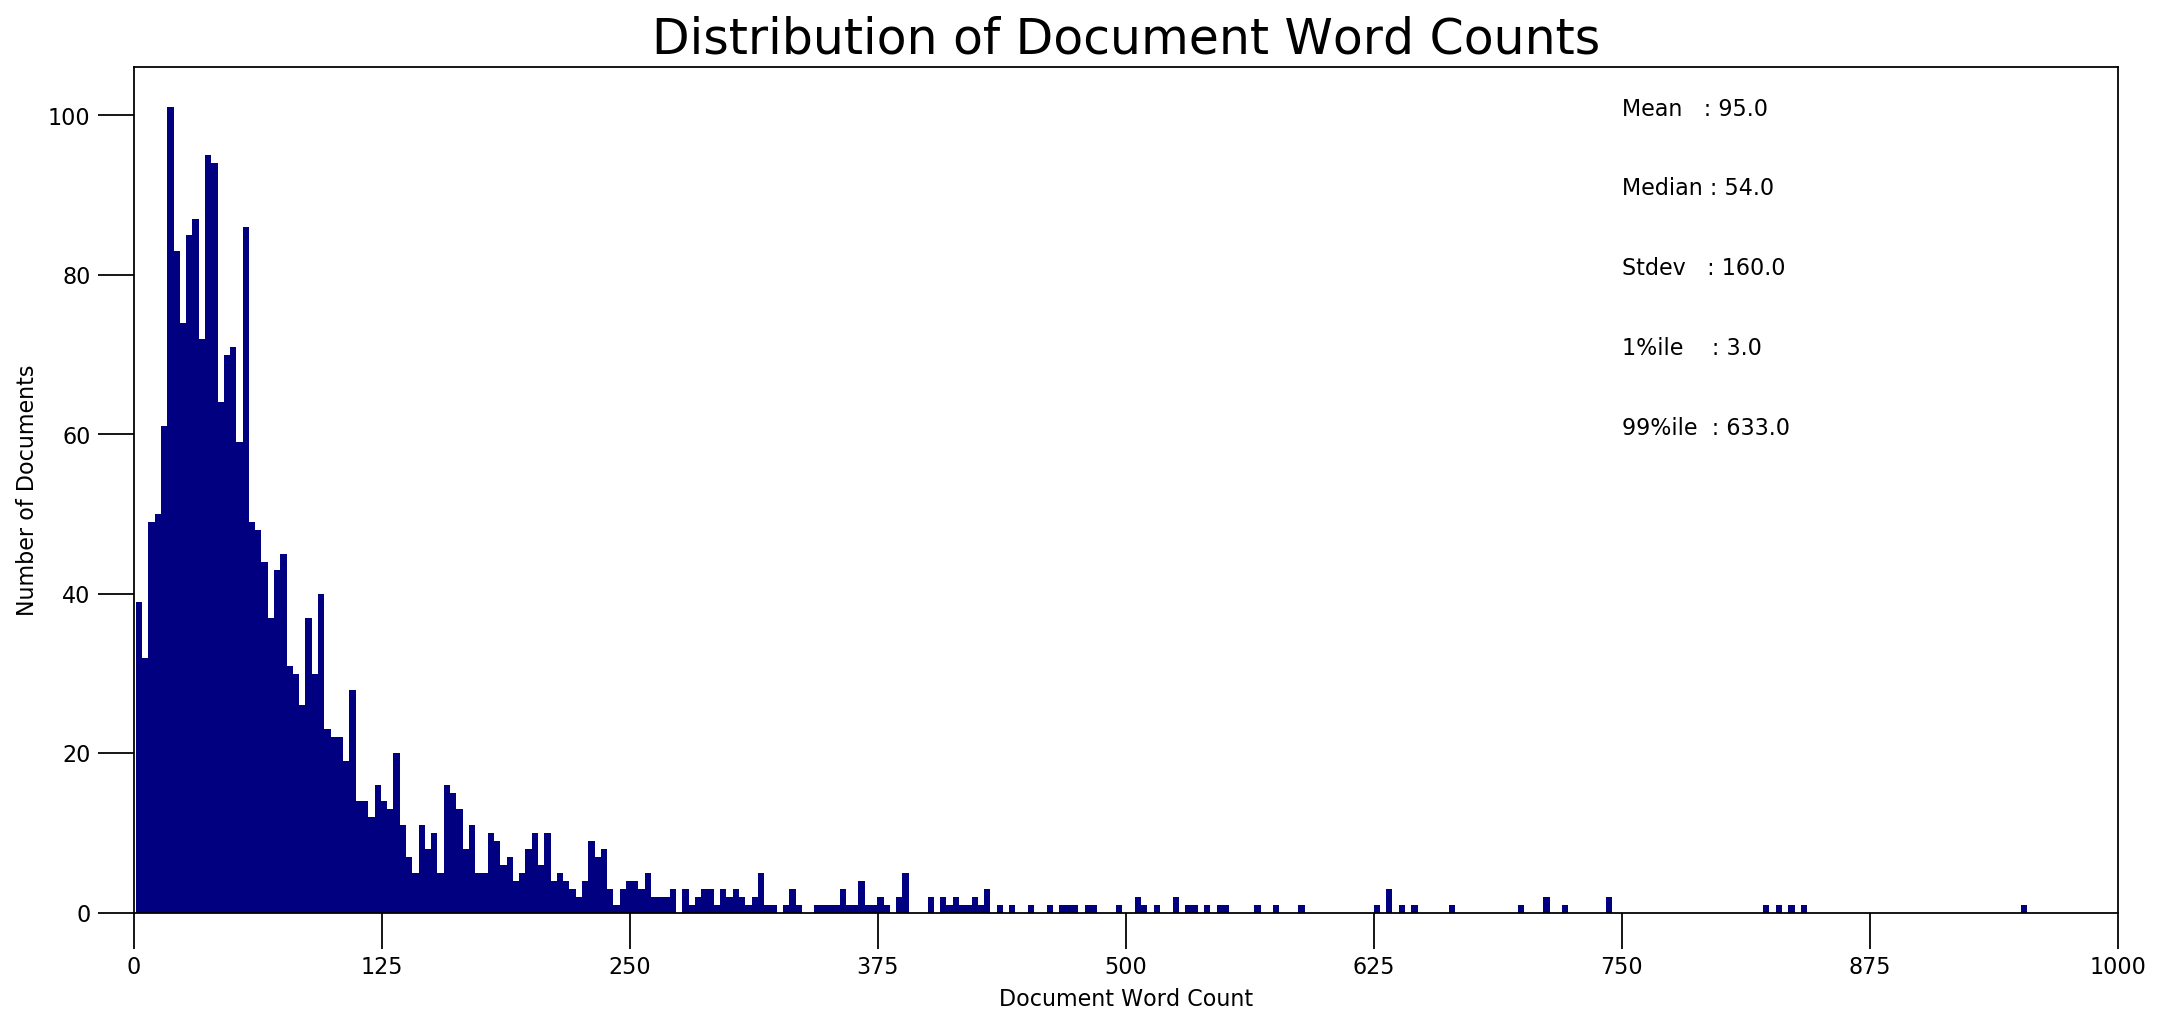

In [26]:
#Frequency Distribution of Word Counts in Documents
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 1000), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

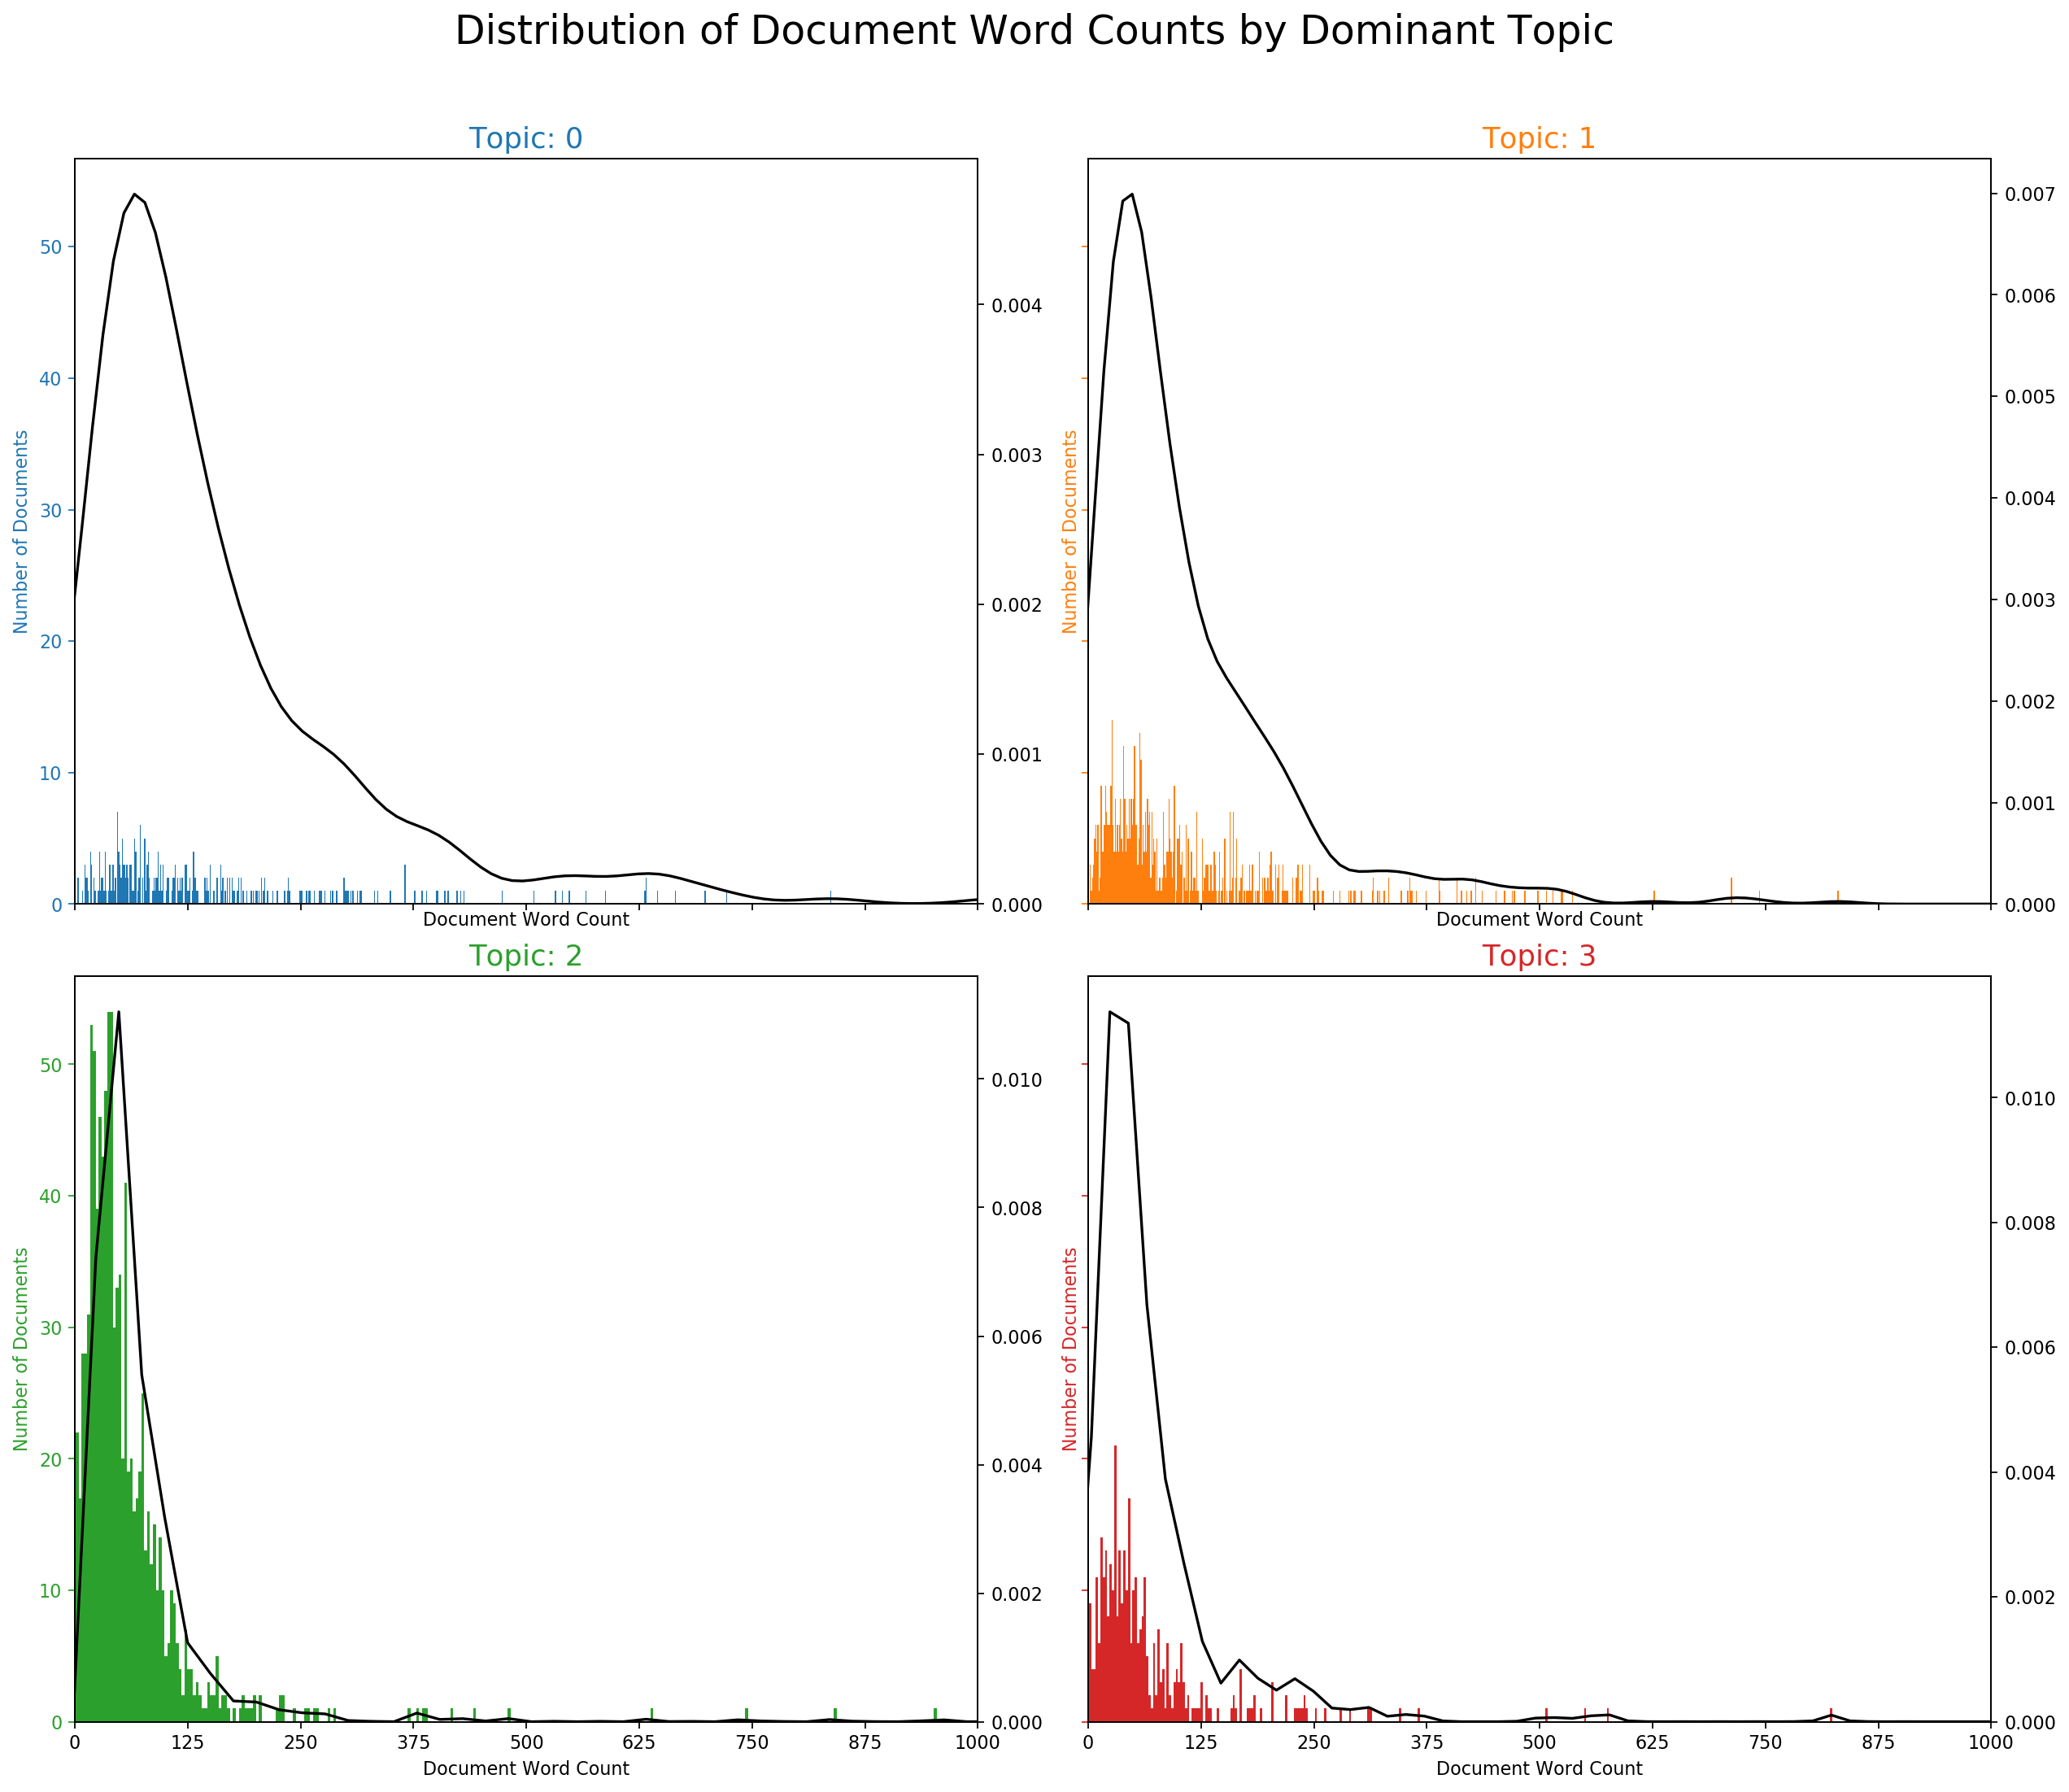

In [27]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

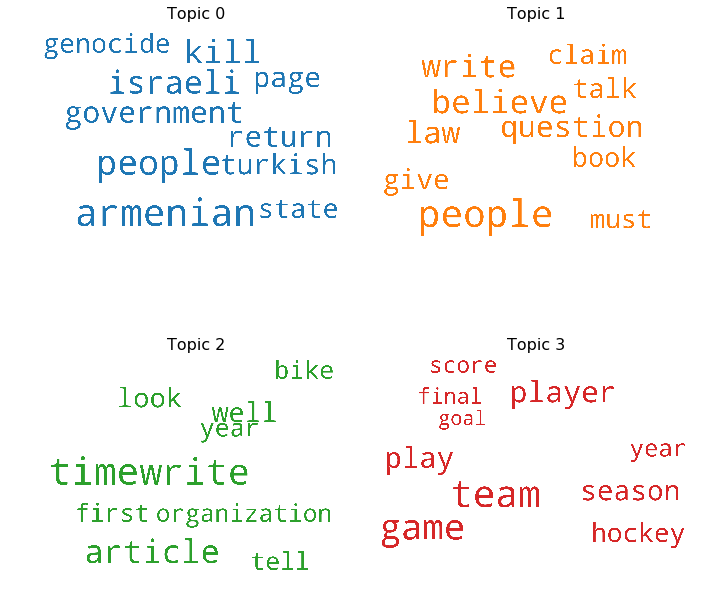

In [28]:
#Word Clouds of Top N Keywords in Each Topic
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [29]:
#Word Counts of Topic Keywords
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in data_ready for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])       

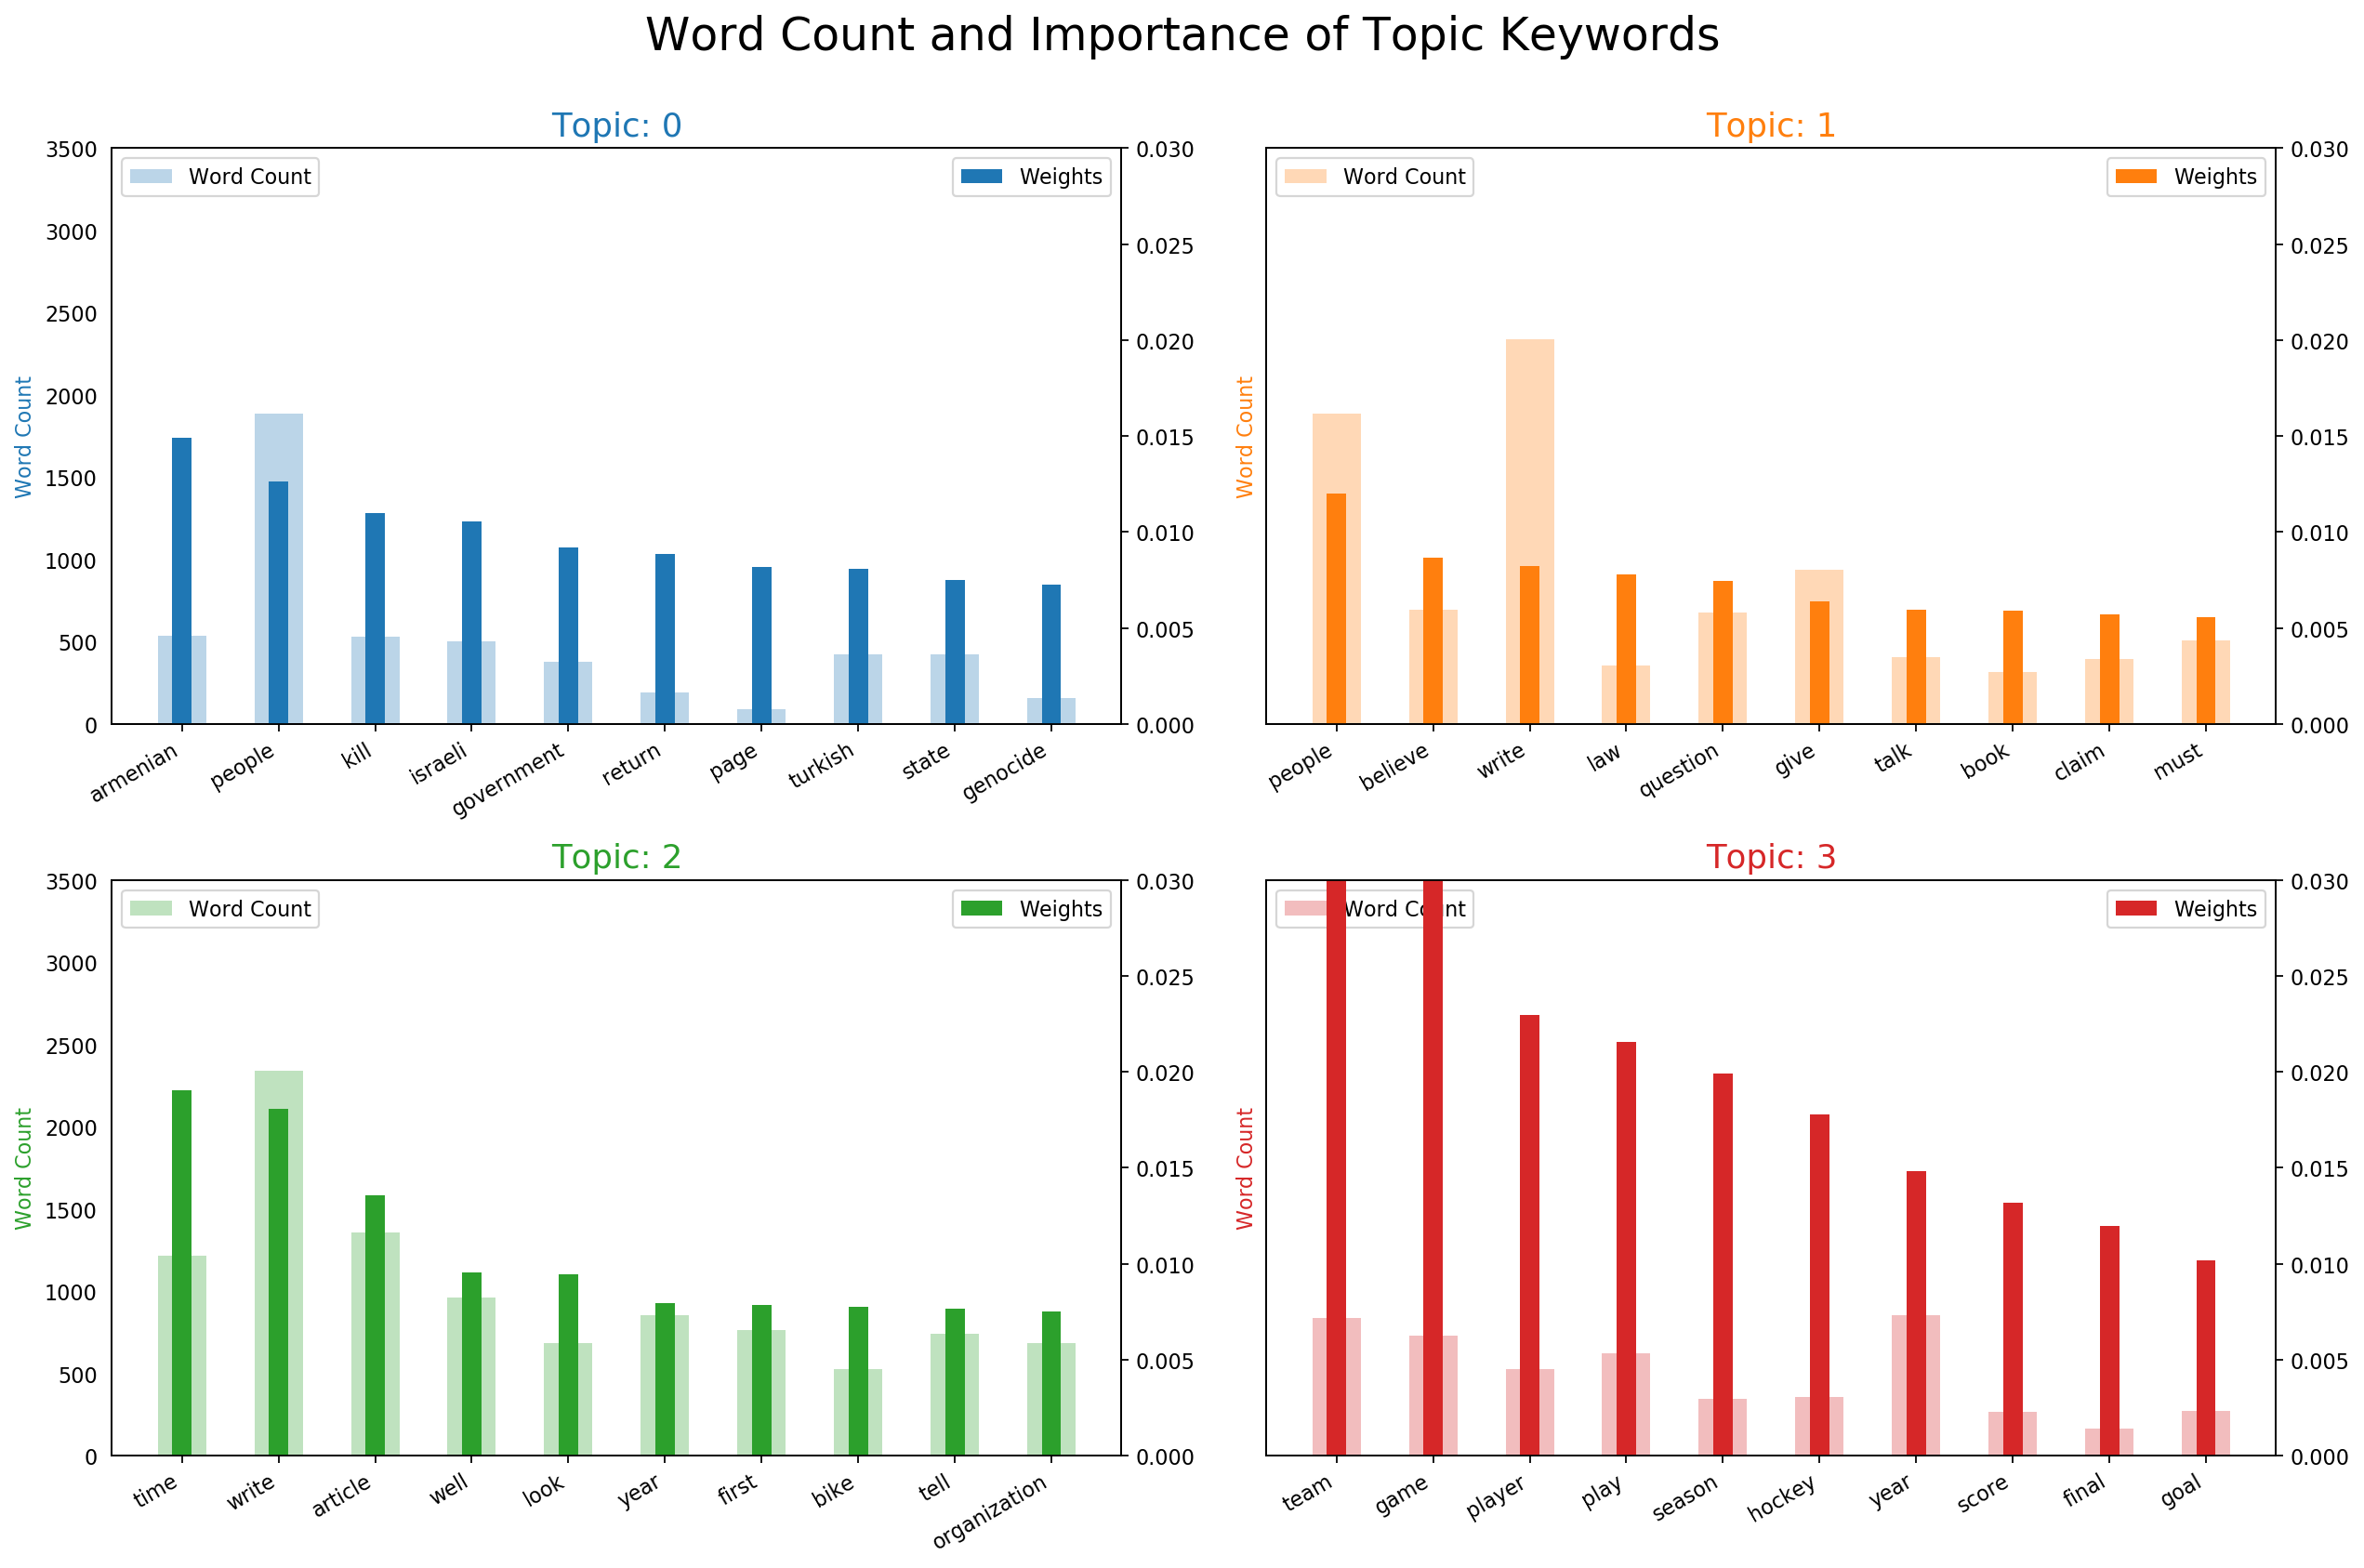

In [30]:
#Sentence Chart Colored by Topic
# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

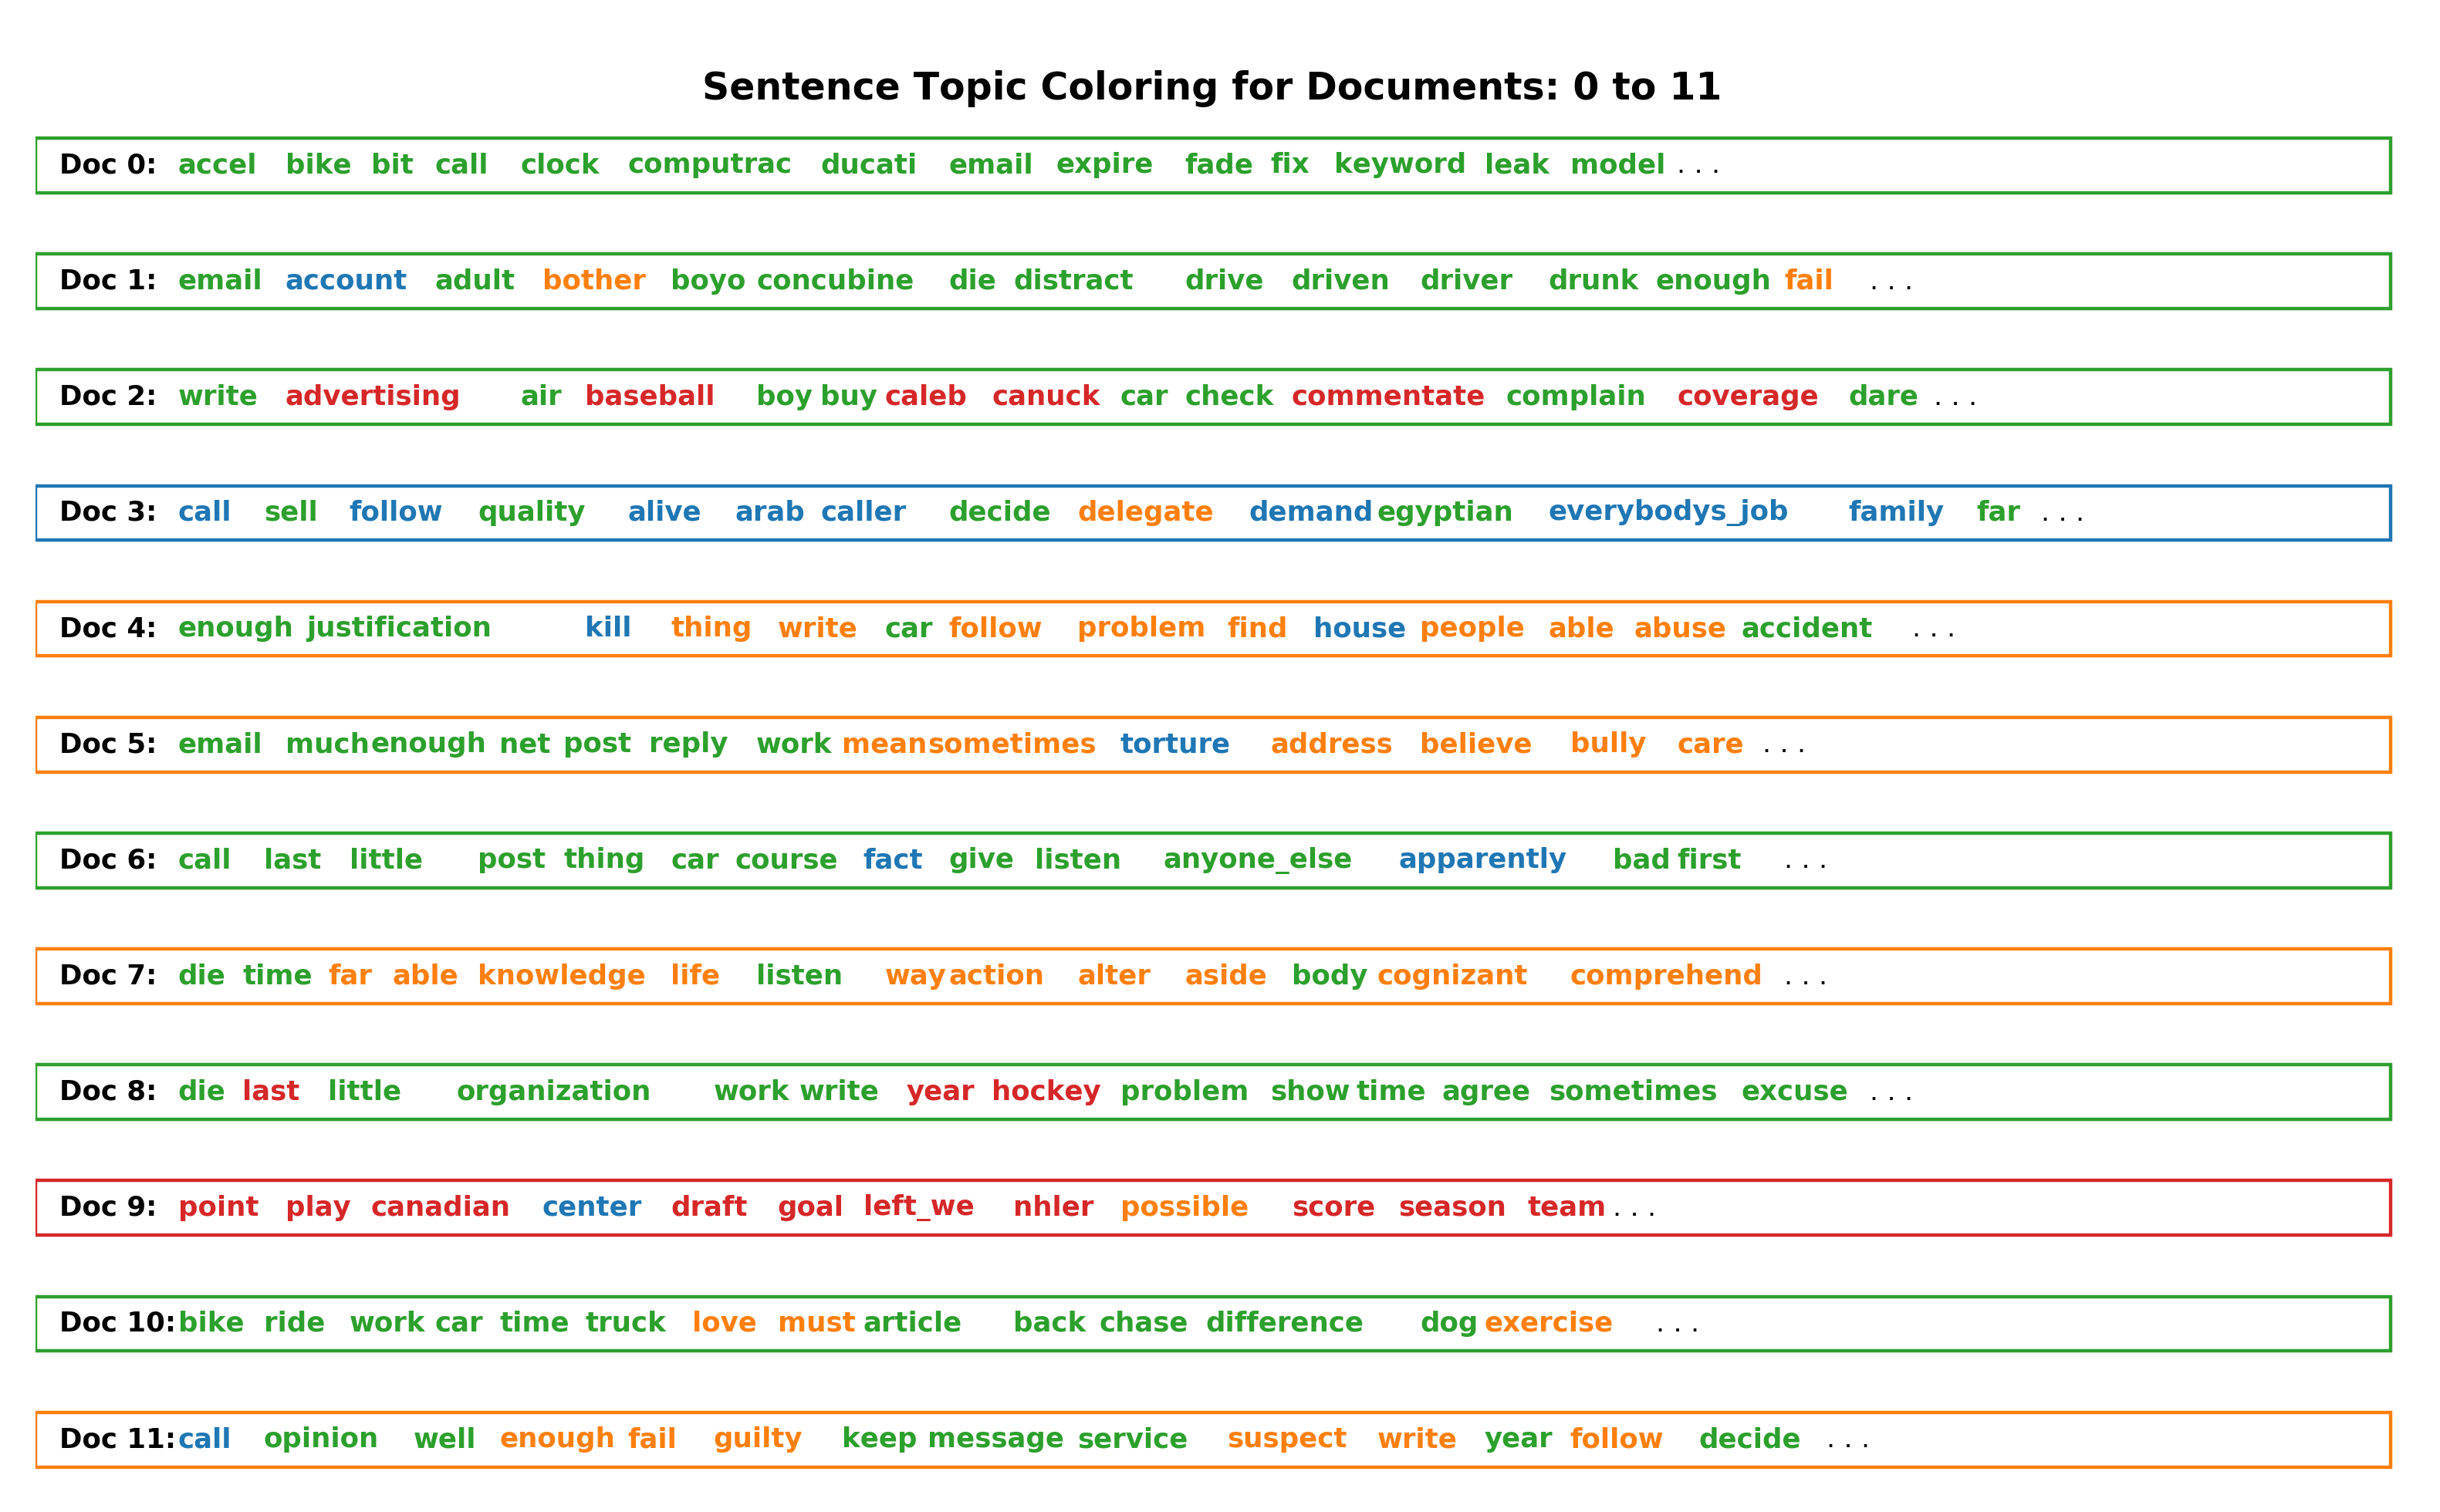

In [31]:
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda_model, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart()

In [32]:
# What are the most discussed topics in the documents
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        topic_percs, wordid_topics, wordid_phivalues = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

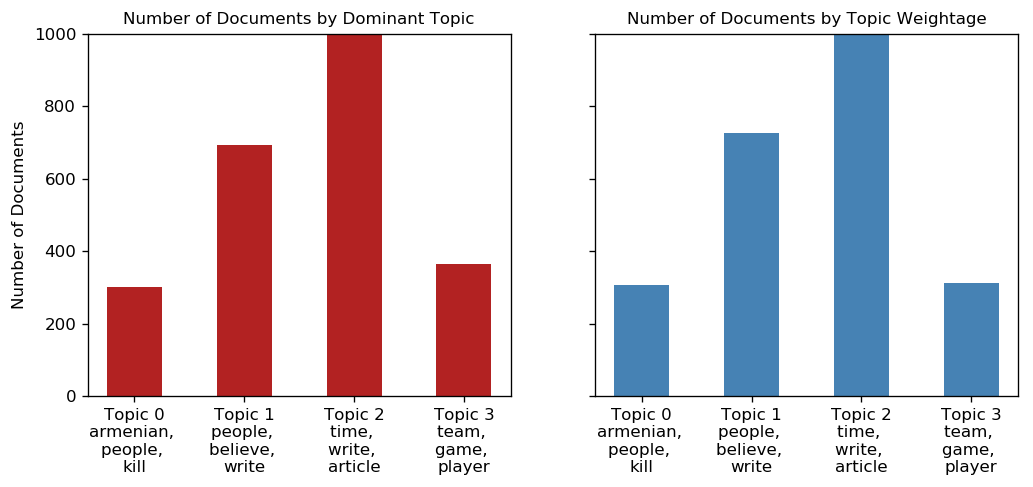

In [33]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [34]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2341 samples in 0.066s...
[t-SNE] Computed neighbors for 2341 samples in 0.178s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2341
[t-SNE] Computed conditional probabilities for sample 2000 / 2341
[t-SNE] Computed conditional probabilities for sample 2341 / 2341
[t-SNE] Mean sigma: 0.035739
[t-SNE] KL divergence after 250 iterations with early exaggeration: 59.121948
[t-SNE] KL divergence after 1000 iterations: 0.547561


Loading BokehJS ...

In [35]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

C:\Users\hrusikesh.p\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.011475  0.219167       1        1  35.701553
1     -0.193740  0.081651       2        1  35.499889
0     -0.112232 -0.264913       3        1  19.020658
3      0.317447 -0.035904       4        1   9.777902, topic_info=     Category         Freq          Term        Total  loglift  logprob
400   Default   835.000000          team   835.000000  30.0000  30.0000
904   Default   746.000000          game   746.000000  29.0000  29.0000
122   Default  1524.000000          time  1524.000000  28.0000  28.0000
75    Default   958.000000          year   958.000000  27.0000  27.0000
1804  Default   501.000000        player   501.000000  26.0000  26.0000
380   Default   470.000000          play   470.000000  25.0000  25.0000
1125  Default   633.000000      armenian   633.000000  24.0000  24.0000
399   Default   435.000000        season   435.000000  23.0000  23.0000
96    Default   388.000000        hockey   388.000000  22.0000  22.0000
50    Default   467.000000          kill   467.000000  21.0000  21.0000
346   Default   753.000000          look   753.000000  20.0000  20.0000
1661  Default   447.000000       israeli   447.000000  19.0000  19.0000
282   Default   685.000000       believe   685.000000  18.0000  18.0000
74    Default  2113.000000         write  2113.000000  17.0000  17.0000
398   Default   287.000000         score   287.000000  16.0000  16.0000
505   Default   391.000000    government   391.000000  15.0000  15.0000
1     Default   619.000000          bike   619.000000  14.0000  14.0000
539   Default   616.000000           law   616.000000  13.0000  13.0000
145   Default  1715.000000        people  1715.000000  12.0000  12.0000
152   Default   377.000000        return   377.000000  11.0000  11.0000
1101  Default   271.000000         final   271.000000  10.0000  10.0000
56    Default   600.000000  organization   600.000000   9.0000   9.0000
108   Default   604.000000         point   604.000000   8.0000   8.0000
2188  Default   348.000000          page   348.000000   7.0000   7.0000
1248  Default   342.000000       turkish   342.000000   6.0000   6.0000
23    Default   897.000000          well   897.000000   5.0000   5.0000
394   Default   222.000000          goal   222.000000   4.0000   4.0000
100   Default   506.000000         leave   506.000000   3.0000   3.0000
1178  Default   309.000000      genocide   309.000000   2.0000   2.0000
155   Default   573.000000         state   573.000000   1.0000   1.0000
...       ...          ...           ...          ...      ...      ...
2059   Topic4    97.715530      schedule    98.432434   2.3177  -5.4086
1064   Topic4    96.720566           ice    97.431366   2.3177  -5.4188
393    Topic4   108.178001         draft   109.018776   2.3173  -5.3069
391    Topic4    77.793388      canadian    78.490891   2.3161  -5.6366
961    Topic4    76.798332       penguin    77.494034   2.3160  -5.6495
3623   Topic4    75.263519          star    75.965897   2.3158  -5.6696
1691   Topic4   110.154037          wing   111.209854   2.3155  -5.2888
1052   Topic4    75.617058    defenseman    76.348976   2.3154  -5.6650
2494   Topic4   111.726059         sweep   112.824821   2.3153  -5.2746
3132   Topic4    70.144150     franchise    70.852432   2.3150  -5.7401
5135   Topic4    96.633331         arena    97.642776   2.3147  -5.4197
98     Topic4    61.538265           jet    62.236530   2.3138  -5.8710
82     Topic4    60.699398        canuck    61.392788   2.3137  -5.8847
1054   Topic4    88.845596         devil    89.865410   2.3136  -5.5037
9387   Topic4    98.485420       belfour    99.914360   2.3106  -5.4007
960    Topic4    66.579941           pen    67.373543   2.3132  -5.7922
1101   Topic4   261.205933         final   271.465179   2.2865  -4.4253
3583   Topic4    75.059425          king    76.066521   2.3117  -5.6724
5138   Topic4    77.124802       